In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve, roc_auc_score, f1_score, accuracy_score

In [14]:
def metrics(clf, X_test, y_test):
    plot_roc_curve(clf, X_test, y_test)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print(f'roc-auc = {round(roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1]), 4)}')
    print(f'accuracy = {round(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test)), 4)}')
    print(f'f1-score = {round(f1_score(y_true=y_test, y_pred=clf.predict(X_test)), 4)}')

In [21]:
X = pd.read_csv('data/X_new.csv', index_col=0)
y = pd.read_csv('data/y_new.csv', index_col=0)

In [16]:
X

,correct,wrong,passed,correct_ratio,hours
user_id,,,,,
2,2.0,0.0,9,1.0,0.1
3,4.0,4.0,15,0.5,0.3
5,2.0,2.0,1,0.5,0.0
8,9.0,21.0,84,0.3,0.2
14,0.0,1.0,3,0.0,0.7
...,...,...,...,...,...
26773,0.0,0.0,1,0.0,0.0
26774,0.0,0.0,1,0.0,0.0
26788,0.0,0.0,1,0.0,0.0


In [22]:
y

,is_gone
user_id,
2,1
3,1
5,1
8,1
14,1
...,...
26773,1
26774,1
26788,1


In [23]:
# Разделим данные на тренировочные и тестовые 4 к 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

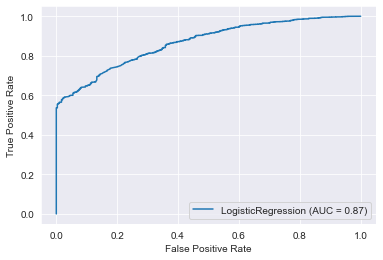

roc-auc = 0.8669
accuracy = 0.6961
f1-score = 0.8057


In [24]:
#LogisticRegression


warnings.filterwarnings("ignore")
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
log_reg = LogisticRegression(random_state=0, max_iter=500, class_weight='balanced')
log_reg_grid = GridSearchCV(log_reg, parameters, cv=5, scoring='f1')
log_reg_grid.fit(X_train, y_train)

metrics(clf=log_reg_grid.best_estimator_, X_test=X_test, y_test=y_test)

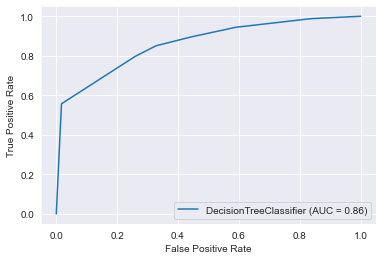

roc-auc = 0.8616
accuracy = 0.9249
f1-score = 0.9605


In [25]:
#Tree


parameters = {'max_depth': range(1, 12), 'min_samples_split': range(1, 10), 'min_samples_leaf': range(1, 10)}
tree = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, param_grid=parameters, cv=3, n_jobs=-1)
tree_grid.fit(X_train, y_train)

metrics(clf=tree_grid.best_estimator_, X_test=X_test, y_test=y_test)

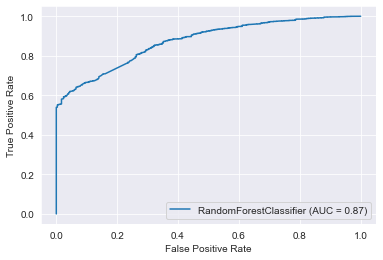

roc-auc = 0.873
accuracy = 0.9285
f1-score = 0.9626


In [26]:
#RandomForest


parameters = {'max_depth': range(1, 12, 2), 'n_estimators': range(10, 50, 10), 'min_samples_split': range(2, 9, 2),
              'min_samples_leaf': range(1, 7)}
forest = RandomForestClassifier()
forest_grid = GridSearchCV(forest, param_grid=parameters, cv=3, n_jobs=-1)
forest_grid.fit(X_train, y_train)

metrics(clf=forest_grid.best_estimator_, X_test=X_test, y_test=y_test)

In [27]:
clf = forest_grid.best_estimator_

In [28]:
X_valid = pd.read_csv('data/X_valid.csv', index_col='user_id')

In [29]:
X_valid

,correct,wrong,passed,correct_ratio,hours
user_id,,,,,
12,1.0,0.0,9,1.000000,0.0
13,29.0,36.0,70,0.446154,35.5
15,10.0,30.0,1,0.250000,0.0
21,24.0,103.0,68,0.188976,18.8
35,7.0,35.0,30,0.166667,46.2
...,...,...,...,...,...
26745,0.0,0.0,1,0.000000,0.0
26768,0.0,0.0,1,0.000000,0.0
26791,0.0,0.0,1,0.000000,0.0


In [34]:
ans = pd.DataFrame(clf.predict_proba(X_valid)[:, 0])

In [35]:
ans['user_id'] = X_valid.index
ans = ans.set_index('user_id')

In [36]:
ans

,0
user_id,
12,0.057405
13,0.523403
15,0.084002
21,0.259076
35,0.144520
...,...
26745,0.000000
26768,0.000000
26791,0.000000


In [37]:
ans.to_csv('ans.csv')

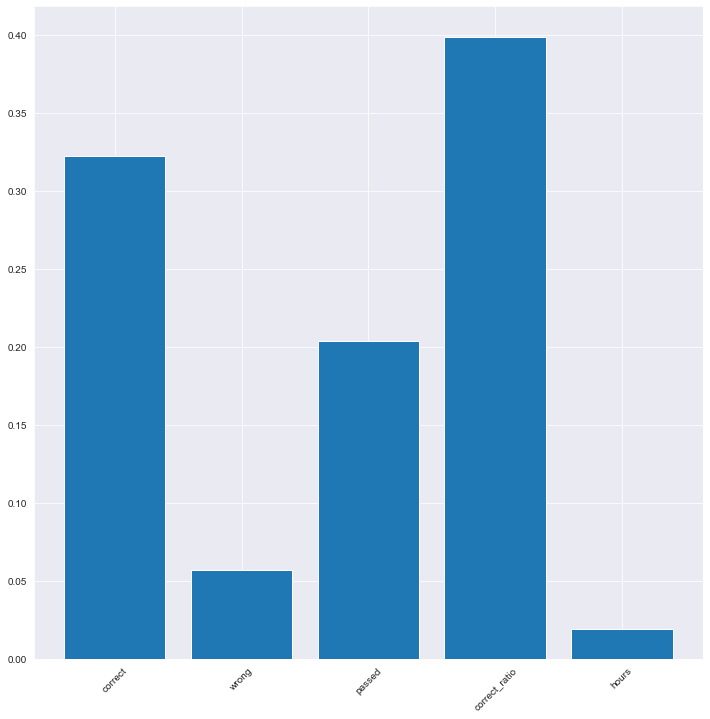

In [15]:
# создаем диаграмму, где ось x - это признак, а Y указывает значимость каждого признака
plt.figure(figsize=(12, 12))
plt.bar(X.columns, forest_grid.best_estimator_.feature_importances_)
plt.xticks(rotation=45)

plt.show()

In [16]:
forest_grid.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=20)

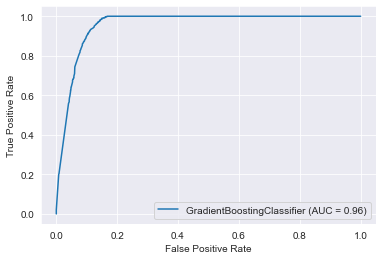

roc-auc = 0.9561
accuracy = 0.9072
f1-score = 0.8969


In [17]:
#GradientBoosting


parameters = {'n_estimators': range(100, 300, 20),
              'max_depth': range(2, 10, 2),
              'criterion': ['friedman_mse', 'squared_error'],
              'learning_rate': np.arange(0.01, 0.04, 0.005),
              'min_samples_leaf': range(2, 10, 3),
              'min_samples_split': range(2, 10, 3),
              'random_state': [0]}
grad_boost = GradientBoostingClassifier()
grad_boost_grid = RandomizedSearchCV(grad_boost, param_distributions=parameters, cv=3, n_jobs=-1)
grad_boost_grid.fit(X_train, y_train)

metrics(clf=grad_boost_grid.best_estimator_, X_test=X_test, y_test=y_test)

In [18]:
grad_boost_grid.best_params_

{'random_state': 0,
 'n_estimators': 280,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_depth': 2,
 'learning_rate': 0.015,
 'criterion': 'friedman_mse'}